# Importing libs

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam # - Works
import random
from glob import glob
import seaborn as sns
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import matplotlib.pyplot as plt
import matplotlib.image as img
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
try:
    tf.config.experimental.set_memory_growth = True
except Exception as ex:
    print(e)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [3]:
! rm -rf /kaggle/working/data/

# Reading input data 

In [4]:
data_dir_train = pathlib.Path("../input/skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
data_dir_test = pathlib.Path("../input/skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration/Test/")

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


# Prepare the dataset

In [6]:
batch_size = 32
img_height = 180
img_width = 180
rnd_seed = 123
random.seed(rnd_seed)

In [7]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [9]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  validation_split=0.9,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 118 files belonging to 9 classes.
Using 106 files for validation.


In [10]:
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


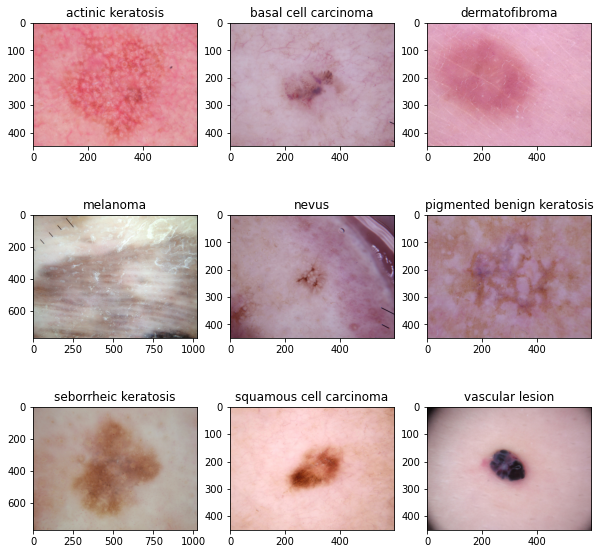

In [11]:
num_classes = len(class_names)
plt.figure(figsize=(10,10))
for i in range(num_classes):
  plt.subplot(3,3,i+1)
  image = img.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)


In [12]:
for image_batch, labels_batch in train_ds.take(1):
    print(image_batch.shape)
    print(labels_batch.shape)

(32, 180, 180, 3)
(32,)


In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Model 1 : standard Model


In [14]:
num_classes = 9
model = Sequential([layers.experimental.preprocessing.Rescaling \
                    (1.0/255,input_shape=(img_height,img_width,3))])

model.add(Conv2D(32, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(64, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(128, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(256, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(512, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Flatten())
model.add(Dense(1024,activation="relu"))
model.add(Dense(units=num_classes, activation= 'softmax'))


In [15]:
opt = Adam(lr=0.001)
model.compile(optimizer= opt,
              loss= SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 128)       0

In [17]:
epochs = 25
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/25
56/56 [==============================] - 24s 103ms/step - loss: 2.0761 - accuracy: 0.2126 - val_loss: 2.0495 - val_accuracy: 0.1544
Epoch 2/25
56/56 [==============================] - 2s 41ms/step - loss: 1.9408 - accuracy: 0.2606 - val_loss: 2.0493 - val_accuracy: 0.1902
Epoch 3/25
56/56 [==============================] - 2s 42ms/step - loss: 1.8396 - accuracy: 0.3103 - val_loss: 1.8689 - val_accuracy: 0.2662
Epoch 4/25
56/56 [==============================] - 2s 41ms/step - loss: 1.6576 - accuracy: 0.4018 - val_loss: 1.5973 - val_accuracy: 0.4362
Epoch 5/25
56/56 [==============================] - 2s 41ms/step - loss: 1.5163 - accuracy: 0.4665 - val_loss: 1.5326 - val_accuracy: 0.4743
Epoch 6/25
56/56 [==============================] - 2s 41ms/step - loss: 1.5374 - accuracy: 0.4515 - val_loss: 1.5225 - val_accuracy: 0.4541
Epoch 7/25
56/56 [==============================] - 2s 42ms/step - loss: 1.4234 - accuracy: 0.4944 - val_loss: 1.4657 - val_accuracy: 0.4765
Epoch 8/25


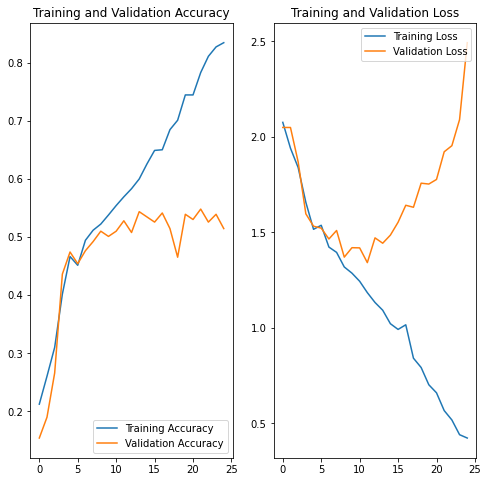

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Findings :
*   The model is overfitting because we can see the difference in accuracy in training data & accuracy in the validation data that is almost 20%. 

*   The training accuracy is just around 70-75% with 25 epochos and the model is yet to learn the many features.

*  data imbalance might be causing the bais to the model.

# Model 2 : Data Augumentation with drop out layer.

In [19]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2),
  ]
)


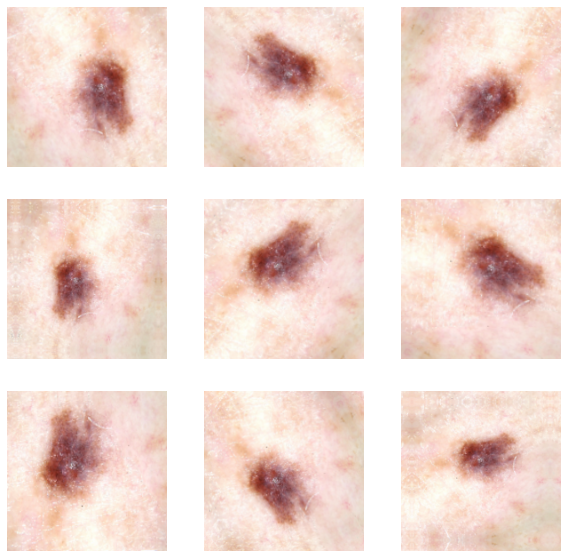

In [20]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")


In [21]:
num_classes = 9
model = Sequential(data_augmentation)
model.add(layers.experimental.preprocessing.Rescaling(1.0/255,input_shape=(img_height,img_width,3)))

model.add(Conv2D(32, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(64, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(128, 3,padding="same",activation='relu'))
model.add(MaxPool2D())
model.add(Dropout(0.15))

model.add(Conv2D(256, 3,padding="same",activation='relu'))
model.add(MaxPool2D())
model.add(Dropout(0.20))

model.add(Conv2D(512, 3,padding="same",activation='relu'))
model.add(MaxPool2D())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024,activation="relu"))
model.add(Dense(units=num_classes, activation= 'softmax'))


In [22]:
opt = Adam(lr=0.001)
model.compile(optimizer=opt,
              loss= SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [23]:
epochs = 25
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/25
56/56 [==============================] - 4s 49ms/step - loss: 2.0811 - accuracy: 0.2009 - val_loss: 2.0327 - val_accuracy: 0.1879
Epoch 2/25
56/56 [==============================] - 3s 46ms/step - loss: 2.0272 - accuracy: 0.1886 - val_loss: 2.0239 - val_accuracy: 0.2058
Epoch 3/25
56/56 [==============================] - 3s 46ms/step - loss: 1.9441 - accuracy: 0.2762 - val_loss: 1.7176 - val_accuracy: 0.3557
Epoch 4/25
56/56 [==============================] - 3s 46ms/step - loss: 1.7373 - accuracy: 0.3571 - val_loss: 1.5741 - val_accuracy: 0.4541
Epoch 5/25
56/56 [==============================] - 3s 46ms/step - loss: 1.5553 - accuracy: 0.4665 - val_loss: 1.5227 - val_accuracy: 0.4832
Epoch 6/25
56/56 [==============================] - 3s 46ms/step - loss: 1.5113 - accuracy: 0.4626 - val_loss: 1.5128 - val_accuracy: 0.4743
Epoch 7/25
56/56 [==============================] - 3s 46ms/step - loss: 1.4865 - accuracy: 0.4682 - val_loss: 1.4985 - val_accuracy: 0.4832
Epoch 8/25
56

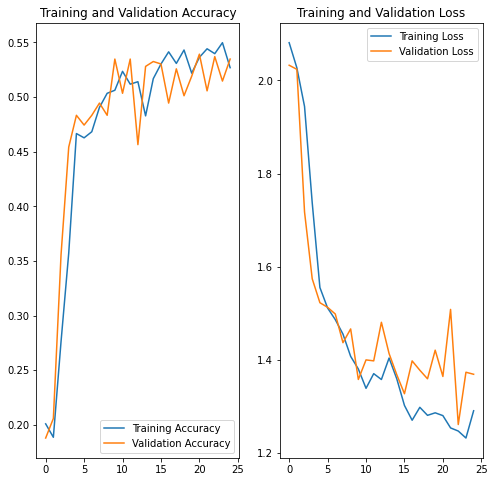

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Findings 
* With data agumenatation and drop layer, the overfitting of the model is adressed to great extend. Earlier the train and validation accuracy difference was nearly 20%, with latest approach it's reduced to 2-3%. 

* The accuracy of the model is compromised heavily and decreased by fair bit from previous venilla model. 

* Considering above 2 points, there is still a scope of lot of improvement of the model.


# Analysing the class imbalance of the data

total training image count = 2239 

-------------------------------------
Class name =  actinic keratosis
count      =  114
proportion =  0.05091558731576597
-------------------------------------
Class name =  basal cell carcinoma
count      =  376
proportion =  0.16793211255024565
-------------------------------------
Class name =  dermatofibroma
count      =  95
proportion =  0.04242965609647164
-------------------------------------
Class name =  melanoma
count      =  438
proportion =  0.19562304600267977
-------------------------------------
Class name =  nevus
count      =  357
proportion =  0.15944618133095131
-------------------------------------
Class name =  pigmented benign keratosis
count      =  462
proportion =  0.20634211701652524
-------------------------------------
Class name =  seborrheic keratosis
count      =  77
proportion =  0.03439035283608754
-------------------------------------
Class name =  squamous cell carcinoma
count      =  181
proportion =  0.08083966056

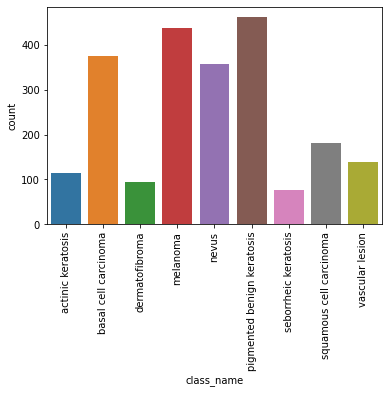

In [25]:
num_classes = len(class_names)
total = 0
all_count = []
class_name = []
for i in range(num_classes):
  count = len(list(data_dir_train.glob(class_names[i]+'/*.jpg')))
  total += count
print("total training image count = {} \n".format(total))
print("-------------------------------------")
for i in range(num_classes):
  count = len(list(data_dir_train.glob(class_names[i]+'/*.jpg')))
  print("Class name = ",class_names[i])
  print("count      = ",count)
  print("proportion = ",count/total)
  print("-------------------------------------")
  all_count.append(count)
  class_name.append(class_names[i])

temp_df = pd.DataFrame(list(zip(all_count, class_name)), columns = ['count', 'class_name'])
sns.barplot(data=temp_df, y="count", x="class_name")
plt.xticks(rotation=90)
plt.show()

## Findings 
Data is hevily imbalance and hence due to that results and predictions will be baised.

# Augmentor : Class balance

Using Augmentor (https://augmentor.readthedocs.io/en/master/) to create the equal distribution of the class.

In [26]:
!pip install Augmentor

In [ ]:
path_to_training_dataset = '../input/skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration/Train/'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i, output_directory='/kaggle/working/data/'+i+'/output/')
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(1000) 

Initialised with 114 image(s) found.
Output directory set to /kaggle/working/data/actinic keratosis/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C5A3E321410>:  60%|██████    | 605/1000 [00:10<00:07, 56.39 Samples/s]                  

In [ ]:
output_dir = pathlib.Path('/kaggle/working/data/')
image_count_train = len(list(output_dir.glob('*/output/*.jpg')))
print(image_count_train)

In [ ]:
num_classes = len(class_names)
total = 0
all_count = []
class_name = []

for i in range(num_classes):
  count = len(list(output_dir.glob(class_names[i]+'/output/*.jpg')))
  total += count
print("total training image count = {} \n".format(total))
print("-------------------------------------")
for i in range(num_classes):
  count = len(list(output_dir.glob(class_names[i]+'/output/*.jpg')))
  print("Class name = ",class_names[i])
  print("count      = ",count)
  print("proportion = ",count/total)
  print("-------------------------------------")
  all_count.append(count)
  class_name.append(class_names[i])


temp_df = pd.DataFrame(list(zip(all_count, class_name)), columns = ['count', 'class_name'])
sns.barplot(data=temp_df, y="count", x="class_name")
plt.xticks(rotation=90)
plt.show()

# Model 3 : Model with Class balance data.

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  output_dir,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  output_dir,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)


In [ ]:
print(train_ds.class_names)

In [ ]:
num_classes = 9
model = Sequential([layers.experimental.preprocessing.Rescaling(1.0/255,input_shape=(img_height,img_width,3))])

model.add(Conv2D(32, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(64, 3,padding="same",activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(128, 3,padding="same",activation='relu'))
model.add(MaxPool2D())
model.add(Dropout(0.15))

model.add(Conv2D(256, 3,padding="same",activation='relu'))
model.add(MaxPool2D())
model.add(Dropout(0.20))

model.add(Conv2D(512, 3,padding="same",activation='relu'))
model.add(MaxPool2D())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024,activation="relu"))
model.add(Dense(units=num_classes, activation= 'softmax'))


In [ ]:
opt = Adam(lr=0.001)
model.compile(optimizer= opt,
              loss = SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [ ]:
epochs = 25
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Evaluation.

In [ ]:
#Create a file to save models
top_model_weights_path = '/kaggle/working/cnn_fc_model.h5'
model.save_weights(top_model_weights_path)


In [ ]:
(eval_loss, eval_accuracy) = model.evaluate(test_ds, batch_size=batch_size, \
                                            verbose=1)

In [ ]:
print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100)) 
print("[INFO] Loss: {}".format(eval_loss)) 